<a href="https://colab.research.google.com/github/giangkarry/Woodblock_image_super_resolution/blob/main/SRGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Setting**


In [ ]:
import torch
batch_size = 32
num_epochs = 150
learning_rate = 1e-4
upscale_factor = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_workers = 2
channel = 3

In [ ]:
print(device)

# Data

In [ ]:
import os
from pathlib import Path
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, ToTensor, Normalize
from PIL import Image
import numpy as np

class HNDataset(Dataset):
  """
  class HNDataset được dùng để tải các cặp ảnh có độ phân giải thấp và cao.
  
  Args:
    data_root (str): Thư mục gốc của bộ dữ liệu.

  Attibutes:
    data_root (str): Thư mục gốc của bộ dữ liệu.
    low_dir (str): Thư mục chứa ảnh có độ phân giải thấp.
    high_dir (str): Thư mục chứa ảnh có độ phân giải cao.
    low_image_list (list): Danh sách các đường dẫn đến các ảnh LR.
    high_image_list (list): Danh sách các đường dẫn đến các ảnh HR.
    lr_transform (torchvision.transforms.Compose): Chuỗi các phép biến đổi ảnh được áp dụng cho ảnh LR.
    hr_transform (torchvision.transform.Compose): Chuỗi các phép biến đổi ảnh được áp dụng cho ảnh HR.

  Methods:
    __len__(self): Trả về kích thước bộ dữ liệu ảnh LR (bằng với kích thước ảnh HR)
    __getitem__(idx): Load, xử lý ảnh LR, HR tại chỉ số idex và trả về chúng
  """
  def __init__(self, data_root):
    super(HNDataset, self).__init__()
    self.data_root = data_root
    self.low_dir = os.path.join(self.data_root, "low")
    self.high_dir = os.path.join(self.data_root, "high")
    self.low_image_list = list(Path(self.low_dir). glob("*.png"))
    self.high_image_list = list(Path(self.high_dir). glob("*.png"))
    self.lr_transform = Compose([
            ToTensor(), #phạm vi [0,1]
        ])
    self.hr_transform = Compose([
            ToTensor(), 
        ])

  def __len__(self):
    return len(self.low_image_list)

  def __getitem__(self, idx):
    low_img = Image.open(self.low_image_list[idx])
    high_img = Image.open(self.high_image_list[idx])
    tensor_low = self.lr_transform(low_img)
    tensor_high = self.hr_transform(high_img)
    return tensor_low, tensor_high

**Train/Val/Test dataloaders**

In [ ]:
from torch.utils.data import DataLoader
path = '/content/drive/MyDrive/Data/6TResize/SRDataset/'

train_set = HNDataset(path + 'train')
val_set = HNDataset(path + 'validation')
test_set = HNDataset(path + 'test')

train_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, num_workers=num_workers, batch_size=batch_size, shuffle=False)

In [ ]:
print(len(train_loader.dataset),len(test_loader.dataset), len(val_loader.dataset))

4800 600 600


# Xây dựng mô hình SRGAN

## Mô hình Generator

In [ ]:
import math
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
  """
  Xây dựng khối phần dư(residual block) trong SRGAN.

  Args:
    channels (int): Số lượng kênh đầu vào.
  
  Attributes:
    residual_block (nn.Sequential): Một chuỗi các layer thực hiện khối mạng phần dư.
  
  Methods:
    forward(x): Thực hiện quá trình forward propagation của residual block.
  """
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.residual_block = nn.Sequential(
        nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(channels),
        nn.PReLU(),
        nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(channels),
    )

  def forward(self, x):
    residual = self.residual_block(x)
    return x + residual # skip_connected, element wise sum


class UpsampleBlock(nn.Module):
  """
  Xây dựng khối tăng kích thước đầu vào.

  Args:
    channels (int): Số kênh đầu vào.
    upscaling_factor (int, optional): Tỷ lệ tăng tỷ lệ, mặc định là 2.

  Attributes: 
    conv (nn.Conv2d): Layer nhân chập 2 chiều.
    pixel_shuffle (nn.PixelShuffle): Layer phân tách kênh và tái ghép các pixel trong một tensor => upsampling
    prelu (nn.PReLU): Layer kích hoạt.
  
  Methods:
    forward(x): forward propagation

  """
  def __init__(self, channels, upscaling_factor=2):
    super(UpsampleBlock, self).__init__()
    self.conv = nn.Conv2d(in_channels=channels, out_channels=channels * upscaling_factor ** 2, kernel_size=3, padding=1)
    self.pixel_shuffle = nn.PixelShuffle(upscaling_factor)  # out: (batch_size, in_channels/(r*r), r*h, r*h)
    self.prelu = nn.PReLU()

  def forward(self, x):
    x = self.conv(x)
    x = self.pixel_shuffle(x)
    x = self.prelu(x)
    return x

class Generator(nn.Module):
  '''
  Tạo mô hình sinh ảnh SR từ ảnh LR.

  Args:
    upscaling_factor (int): Hệ số tăng tỷ lệ ảnh, mặc định là 4.
    residual_blocks_num (int): Số lượng Residual Block được sử dụng trong mô hình

  '''
  def __init__(self, upscaling_factor=4, residual_blocks_num=5):
    super(Generator, self).__init__()
    self.upscaling_factor = upscaling_factor
    self.residual_blocks_num = residual_blocks_num
    self.upsample_block_num = int(math.log(self.upscaling_factor, 2)) # mỗi lần dùng UpsampleBLock sẽ tăng w,h lên gấp đôi
    
    #First layers
    self.block1 = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, padding=4), #rgb -> in_channel = 3
      nn.PReLU()
    )
    # Resedual blocks
    block2 = [ResidualBlock(64) for _ in range(self.residual_blocks_num)]
    self.block2 = nn.Sequential(*block2)
    
    # Second conv layer post residual blocks
    self.block3 = nn.Sequential(
      nn.Conv2d(64, 64, kernel_size=3, padding=1),
      nn.BatchNorm2d(64)
    )
    # Upsampling layers
    block4 = [UpsampleBlock(64, 2) for _ in range(self.upsample_block_num)]
    block4.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
    self.block4 = nn.Sequential(*block4)

  def forward(self, x):
    block1 = self.block1(x)
    block2 = self.block2(block1)
    block3 = self.block3(block2)
    block4 = self.block4(block1 + block3)

    return (torch.tanh(block4) + 1) / 2 # thay đổi giá trị trong khoảng [0,1]

## Mô hình Discriminator

In [ ]:

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    '''
    Model's features
    '''
    self.net = nn.Sequential(
      nn.Conv2d(3, 64, kernel_size=3, padding=1),
      nn.LeakyReLU(0.2),

      nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1), #giảm w,h đi 2 lần
      nn.BatchNorm2d(64),
      nn.LeakyReLU(0.2),

      nn.Conv2d(64, 128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(0.2),

      nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(0.2),

      nn.Conv2d(128, 256, kernel_size=3, padding=1),
      nn.BatchNorm2d(256),
      nn.LeakyReLU(0.2),

      nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(256),
      nn.LeakyReLU(0.2),

      nn.Conv2d(256, 512, kernel_size=3, padding=1),
      nn.BatchNorm2d(512),
      nn.LeakyReLU(0.2),

      nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(512),
      nn.LeakyReLU(0.2)

    )
    # self.adaptive_pool = nn.AdaptiveAvgPool2d(1) #(batch_size, 512,1,1)
    # self.fc1 = nn.Linear(in_features=128, out_features=256)
    # self.leaky_relu = nn.LeakyReLU(0.2)
    # self.fc2 = nn.Linear(256, 1)
    '''
    Dense layer
    '''
    self.adaptive_pool = nn.AdaptiveAvgPool2d(1) #(batch_size, 512,1,1)
    self.fc1 = nn.Linear(in_features=512, out_features=1024)
    self.leaky_relu = nn.LeakyReLU(0.2)
    self.fc2 = nn.Linear(1024, 1)

  def forward(self, x):
    batch_size = x.size(0)
    x = self.net(x)
    x = self.adaptive_pool(x)
    x = self.fc1(x.view(batch_size,-1))
    x = self.leaky_relu(x)
    x = self.fc2(x) # logit
    return torch.sigmoid(x.view(batch_size))


# Loss

In [ ]:
import torch
from torch import nn
from torchvision.models.vgg import vgg19

class WithLoss_G(nn.Module): #Perceptual
  def __init__(self):
    super(WithLoss_G, self).__init__()
    vgg = vgg19(pretrained=True)
    
    feature_extractor = nn.Sequential(*list(vgg.features)[:36]).eval()
    for param in feature_extractor.parameters():
      param.requires_grad = False
    
    self.mse_loss = nn.MSELoss() #MSE loss
    self.adversarial_loss = nn.BCELoss()
    self.vgg_loss =VGGLoss()
    self.tv_loss = TVLoss()
  
  '''
  fake_img = Generator(LR image) #SR
  label_pred = Discriminator(fake_img)
  target_label = torch.ones_like(label_pred)
  '''
  def forward(self, fake_img, hr_img, label_pred, target_label): 
    #MSE loss 
    mse_loss = self.mse_loss(fake_img, hr_img)

    #Adversarial loss
    adversarial_loss = self.adversarial_loss(label_pred,target_label)

    #Content loss/perceptual loss?
    content_loss = self.vgg_loss(fake_img, hr_img)
    
    #TV Loss
    tv_loss = self.tv_loss(fake_img)
    return mse_loss + 1e-3 * adversarial_loss + 6e-3 * content_loss + 2e-8 * tv_loss

class WithLoss_D(nn.Module):
  def __init__(self):
    super(WithLoss_D, self).__init__()
    self.cross_ent = nn.BCELoss()
  '''
  real_pred = Discriminator(HR image)
  fake_pred = Discriminator(SR image)
  '''
  def forward(self, real_pred, fake_pred):
    #return 1 - real_pred.mean() + fake_pred.mean()
    real_label = torch.ones_like(real_pred)
    fake_label = torch.zeros_like(fake_pred)
    loss_D_real = self.cross_ent(real_pred, real_label)
    loss_D_fake = self.cross_ent(fake_pred, fake_label)
    return (loss_D_real + loss_D_fake)/2

class VGGLoss(nn.Module):
  def __init__(self):
    super(VGGLoss, self).__init__()
    self.vgg = vgg19(pretrained=True)
    self.feature_extractor = nn.Sequential(*list(self.vgg.features)[:36]).eval()
    for param in self.feature_extractor.parameters():
      param.requires_grad = False
  def forward(self, fake_img, hr_img):
    features_input = self.feature_extractor(fake_img)
    features_target = self.feature_extractor(hr_img)
    content_loss = nn.MSELoss()(features_input, features_target)
    return content_loss

class TVLoss(nn.Module):
  '''
  Class TVLoss tính toán total variation loss cho batch

  Arg:
    size_average (boolean): trả về giá trị TVLoss trung bình cho toàn bộ batch(True) hay trả về trung bình cho mỗi phần tử trong batch(False)
  '''
  def __init__(self, size_average=True):
    super(TVLoss, self).__init__()
    self.size_average = size_average

  def forward(self, x):
    '''
    Tính TV Loss cho x
    Arg:
      x (tensor): tensor đầu vào có kích thước (batch_size, channels, height, width)
    Return:
      Tensor có kích thước (batch_size) hoặc scalar
    '''
    batch_size, channels, height, width = x.shape
    dy = x[:,:,1:,:]-x[:,:,:-1,:]
    dx = x[:,:,:,1:]-x[:,:,:,:-1]
    sum_axis = [1,2,3]
    sum_dy = torch.sum(torch.abs(dy), dim=sum_axis) # (batch_size)
    sum_dx = torch.sum(torch.abs(dx), dim=sum_axis) # (batch_size)
    total_val = sum_dy + sum_dx # |I_(x,y+1,c)- I_(x,y,c)| + |I_(x+1,y,c)- I_(x,y,c)|
    if (self.size_average):
      return total_val.sum()/x.numel() #scalar  
    else:
      return total_val/(channels*height*width)

  

# Các chỉ số đánh giá

In [ ]:
import torch
import torch.nn.functional as F
from math import exp
class SSIM:
  '''
  Lớp SSIM tính toán chỉ số SSIM giữa hai hình ảnh

  '''
  def __init__(self, window_size=11, sigma=1.5, size_average=True):
    '''
    Khởi tạo lớp SSIM với các tham số đầu vào:
      window_size(int): kích thước cửa sổ để tính toán chỉ số SSIM. Mặc định là 11
      sigma(float): giá trị độ lệch chuẩn của bộ lọc Gaussian để tạo ra cửa sổ. Mặc định là 1.5
      size_average(boolean): trả về giá trị SSIM trung bình cho toàn bộ batch (True) hay trả về trung bình cho mỗi hình ảnh trong batch(False). Mặc định là True

    '''
    self.window_size = window_size
    self.size_average = size_average
    self.sigma = sigma

  def gaussian(self):
    '''
    Return:
      gauss(torch.Tensor): bộ lọc Gaussian 1D với số phần tử bằng window_size
    '''
    gauss = torch.Tensor([exp(-(x-self.window_size//2)**2/float(2*self.sigma**2))for x in range(self.window_size)]) 
    return gauss/gauss.sum() # (window_size)
  
  def create_window(self, channels, groups):
    '''
    Tạo cửa sổ 2D từ bộ lọc Gaussian 1D

    Args:
      channels (int): số kênh của hình ảnh đầu vào
      groups (int): số lượng groups được sử dụng trong phép toán convolution

    Return:
      window (torch.Tensor): cửa sổ 2D với kích thước window_size x window_size
    '''
    _1d_window = self.gaussian().unsqueeze(1) #(window_size, 1)
    _2d_window = torch.mm(_1d_window, _1d_window.t()).unsqueeze(0).unsqueeze(0) # (1,1,window_size, window_size)
    window = _2d_window.expand(channels, channels//groups, self.window_size, self.window_size).contiguous()
    return window # (channel, channel/group, window_size, window_size): (3, 1, 11,11)

  def ssim(self, img1, img2):
    '''
    Tính chỉ số SSIM giữa hai hình ảnh đầu vào

    Args:
      img1(torch.Tensor): ảnh thứ nhất, kích thước (batch_size, channel, height, width)
      img2(torch.Tensor): ảnhthứ hai, kích thước (batch_size, channel, height, width)

    Returns:
      ssim(torch.Tensor): giá trị ssim giữa hai hình ảnh. 
        Nếu 'size_average' là True, trả về một vô hướng đại diện cho trung bình SSIM trên toàn bộ batch.
        Nếu 'size_average' là False, trả về một tensor đại diện cho SSIM cho mỗi ảnh trong batch

    '''
    channel = img1.shape[1] # <=>img1.size()[1] hoặc (_, channel,_,_) = img1.size(): int
    window = self.create_window(channel, channel) # (3,1,11,11)
    if img1.is_cuda:
      window = window.cuda(img1.get_device())
    mu1 = F.conv2d(img1, window, padding=(self.window_size-1)//2, groups=channel) # (N,c,h,w)
    mu2 = F.conv2d(img2, window, padding=(self.window_size-1)//2, groups=channel) #(N,c,h,w)

    mu1_sq = mu1**2 #(N,c,h,w)
    mu2_sq = mu2**2 #(N,c,h,w)
    mu1_mu2 = mu1*mu2 #(N,c,h,w)

    #sigma^2 = E(x^2)-(E(x))^2
    #sigma_xy = E(xy)-E(x)E(y)
    sigma1_sq = F.conv2d(img1**2, window, padding=(self.window_size-1)//2, groups=channel)-mu1_sq #(N,c,h,w)
    sigma2_sq = F.conv2d(img2**2, window, padding=(self.window_size-1)//2, groups=channel)-mu2_sq #(N,c,h,w)
    sigma12 = F.conv2d(img1*img2, window, padding=(self.window_size-1)//2, groups=channel)-mu1_mu2 #(N,c,h,w)

    # C1=(k1L)**2, C2=(k2L)^2 trong đó mặc định của k1=0.01, k2=0.03
    # L là dynamic range của giá trị pixel (thường 2^bit_per_pixel - 1: max-min)
    # compute coefficients
    C1 = 0.01**2
    C2 = 0.03**2
    
    ssim = ((2.0*mu1_mu2 + C1)*(2.0*sigma12 + C2))/((mu1_sq +mu2_sq+C1)*(sigma1_sq+sigma2_sq+C2)) #(N, c, h, w)
    if self.size_average:
      return ssim.mean() 
    else:
      return ssim.mean(dim=(1,2,3))# tương tự ssim.mean(1).mean(1).mean(1) # batch_size

class PSNR:
  def __init__(self):
    pass
  def update(self, sr, hr):
    data_range = 1
    dim = tuple(range(1,hr.ndim)) #(1,2,3)
    mse_error = torch.pow((sr-hr),2).mean(dim=dim) # (batch_size)
    batch_psnr = 10.0 * torch.log10(1/(mse_error)) #(batch_size)
    return batch_psnr


# Huấn luyện mô hình

In [ ]:
# from torch.types import Device
from torch.nn import functional as F
import os 
from math import log10
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
# from torchvision.transforms import toTenSor
from torchvision import utils
from torch.autograd import Variable
from tqdm import tqdm # tạo ra thanh tiến trình và các thông báo tiến trình cho các vòng lặp
import pandas as pd

class SRGANTrain:
  def __init__(self, netG, netD, train_loader, val_loader, generator_criterion, discriminator_criterion, batch_size, learning_rate, num_epochs, ssim, psnr, device='cpu'):
    self.netG = netG
    self.netD = netD
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.generator_criterion = generator_criterion
    self.discriminator_criterion = discriminator_criterion
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    self.num_epochs = num_epochs
    self.device = device
    self.ssim = ssim
    self.psnr = psnr

    self.optimizerD = optim.Adam(netD.parameters(), lr=learning_rate)
    self.optimizerG = optim.Adam(netG.parameters(), lr=learning_rate)
    self.results_train = {'d_loss':[], 'g_loss':[],'psnr':[], 'ssim':[]}
  def get_results_train(self):
    return self.results_train
  def _train_discriminator(self, lr_img, hr_img, running_results):
    lr_img = lr_img.to(self.device)
    hr_img = hr_img.to(self.device)
    
    # Tạo các ảnh fake high_resolution từ generator
    fake_img = self.netG(lr_img)
    
    # Train discriminator để phát hiện ảnh real và fake
    real_pred = self.netD(hr_img)
    fake_pred = self.netD(fake_img)

    # Tính toán loss cho discriminator
    d_loss = self.discriminator_criterion(real_pred, fake_pred) # loss trung bình của samples trong mini_batch
    
    self.optimizerD.zero_grad()
    # Backpropagation và update trọng số
    d_loss.backward()
    self.optimizerD.step()

    running_results['d_loss'] += d_loss.item() * self.batch_size

  def _train_generator(self, lr_img, hr_img, running_results):
    lr_img = lr_img.to(self.device)
    hr_img = hr_img.to(self.device)
    
    fake_img = self.netG(lr_img)
    
    #Train generator để tạo ra nhiều ảnh realistic
    fake_pred = self.netD(fake_img)
    real_label = torch.ones(self.batch_size).to(self.device)
    
    g_loss = self.generator_criterion(fake_img, hr_img, fake_pred, real_label)

    #Optimizer
    self.optimizerG.zero_grad()
    g_loss.backward()
    self.optimizerG.step()

    running_results['g_loss'] += g_loss.item() * self.batch_size

  def val(self, lr, hr, val_results):
    lr = lr.to(self.device)
    hr = hr.to(self.device)
    sr = self.netG(lr)
    
    #Tính các chỉ số mse, ssim, psnr
    
    batch_ssim = self.ssim.ssim(sr, hr) # (batch_size)
    batch_psnr = self.psnr.update(sr,hr) # (batch_size)
    val_results['ssim'] += torch.sum(batch_ssim)
    val_results['psnr'] += torch.sum(batch_psnr)


  def train(self):
    for epoch in range(self.num_epochs):
      # Khởi tạo progress bar
      train_bar = tqdm(self.train_loader)
      running_results = {'samples': 0, 'd_loss': 0, 'g_loss': 0}
      
      self.netG.train()
      self.netD.train()
      for lr_img, hr_img in train_bar:
        running_results['samples'] += self.batch_size
        #Train discriminator
        self._train_discriminator(lr_img, hr_img, running_results)
        
        #Train generator
        self._train_generator(lr_img, hr_img, running_results)

        train_bar.set_description (
          desc='Epoch: [%d/%d] Loss_D: %.4f Loss_G: %.4f samples: %d' % (
              epoch+1, self.num_epochs, running_results['d_loss'] / running_results['samples'],
              running_results['g_loss'] / running_results['samples'], running_results['samples']))
      with torch.no_grad():
        netG.eval()
        # Khởi tạo progress bar
        val_bar = tqdm(self.val_loader)
        val_results = {'ssim': 0, 'psnr': 0, 'samples':0}
        for lr, hr in val_bar:
          val_results['samples'] += self.batch_size ############
          self.val(lr,hr, val_results)
      
          val_bar.set_description (
            desc='SSIM: %.4f PSNR: %.4f' % (
                val_results['ssim'] / val_results['samples'],
                val_results['psnr'] / val_results['samples']))
          
      self.results_train['psnr'].append((val_results['psnr']/ val_results['samples']).item())
      self.results_train['ssim'].append((val_results['ssim'] / val_results['samples']).item())

      if (epoch+1)%5 == 0:
        torch.save(netG.state_dict(), '/content/drive/MyDrive/TRAINAGAIN/MAPT/netG_epoch_%d_%d.pth' % (upscale_factor, epoch+1))
        torch.save(netD.state_dict(), '/content/drive/MyDrive/TRAINAGAIN/MAPT/netD_epoch_%d_%d.pth' % (upscale_factor, epoch+1))

In [ ]:
# Khởi tạo mô hình và bộ tối ưu
netG = Generator(upscale_factor).to(device)
netD = Discriminator().to(device)
ssim = SSIM(size_average=False)
psnr = PSNR()
#Khởi tạo loss
generator_criterion = WithLoss_G().to(device)
discriminator_criterion = WithLoss_D().to(device)

train = SRGANTrain(netG, netD, train_loader, val_loader, generator_criterion, discriminator_criterion, batch_size, learning_rate, num_epochs, ssim, psnr,device)
train.train()
results = train.get_results_train()

# Đánh giá mô hình/Test benchmark

In [ ]:
class SRGANTest:
  def __init__(self, G_model, state_dict_model, test_loader, device, psnr, ssim):
    self.G_model = G_model
    self.state_dict_model = state_dict_model
    self.test_loader = test_loader
    self.device = device
    self.psnr = psnr
    self.ssim = ssim
    self.results = {'psnr':0, 'ssim':0}
  def test(self):
    with torch.no_grad():
      self.G_model = self.G_model.to(self.device)
      self.G_model.load_state_dict(torch.load(self.state_dict_model))
      test_bar = tqdm(self.test_loader)
      for lr, hr in test_bar:
        lr = lr.to(self.device)
        hr = hr.to(self.device)
        sr = self.G_model(lr)
        #Tính các chỉ số mse, ssim, psnr
        self.results['ssim'] += torch.sum(self.ssim.ssim(sr, hr)).item()
        self.results['psnr'] += torch.sum(self.psnr.update(sr,hr)).item()
      # Tính trung bình các chỉ số cho toàn bộ dữ liệu
      self.results['psnr'] = self.results['psnr']/len(self.test_loader.dataset)
      self.results['ssim'] = self.results['ssim']/len(self.test_loader.dataset)
    return self.results

In [ ]:
G_model = Generator(upscale_factor).eval()
psnr = PSNR()
ssim = SSIM(size_average=False)
state_dict_model = '/content/drive/MyDrive/Trainagain/Epoch_100/MAPT/netG_epoch_4_100.pth'
test_model = SRGANTest(G_model, state_dict_model, test_loader, device, psnr, ssim)
results = test_model.test()
print(results)

100%|██████████| 19/19 [00:04<00:00,  4.46it/s]

{'psnr': 33.09589803059896, 'ssim': 0.9433213424682617}


# Sử dụng mô hình

In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms.transforms import ToPILImage
class UpScaleImageSRGAN:
  def __init__(self, G_model, state_dict_model, ssim, psnr, device, lr_img, hr_img=None):
    self.G_model = G_model
    self.state_dict_model = state_dict_model
    self.ssim = ssim
    self.psnr = psnr
    self.device = device
    self.lr_img = lr_img
    self.hr_img = hr_img
    self.sr_img = None
    self.results = {'ssim':0, 'psnr':0}
  def sr_generator(self):
    with torch.no_grad():
      self.G_model = self.G_model.to(device)
      self.G_model.load_state_dict(torch.load(self.state_dict_model))
      lr_img = ToTensor()(self.lr_img).unsqueeze(0).to(self.device) #(1,channels, h,w)
      self.sr_img = self.G_model(lr_img)
      return self.sr_img # (1, channels, h, w)
  def metrics_calculation(self):
    with torch.no_grad():
      self.sr_img = self.sr_generator()
      hr_img = ToTensor()(self.hr_img).unsqueeze(0).to(self.device)
      self.results['ssim'] = self.ssim.ssim(self.sr_img,hr_img).item()
      self.results['psnr'] = self.psnr.update(self.sr_img,hr_img).item()
    return self.results
  def get_sr_img(self):
    with torch.no_grad():
      self.sr_img = self.sr_generator()
      self.sr_img = ToPILImage()(self.sr_img.squeeze().cpu())
      # self.sr_img = ToPILImage()(self.sr_img[0].data.cpu())
    return self.sr_img


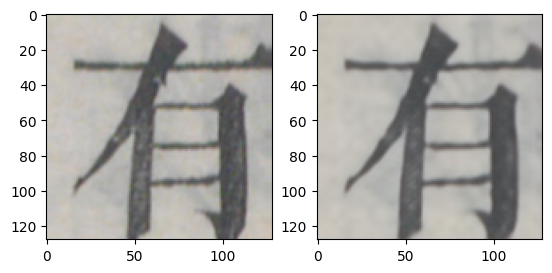

{'ssim': 0.9450325965881348, 'psnr': 35.16865921020508}


In [ ]:
lr_path = '/content/drive/MyDrive/Data/6TResize/SRDataset/test/low/1074.png'
hr_path = '/content/drive/MyDrive/Data/6TResize/SRDataset/test/high/1074.png'
state_dict_model = '/content/drive/MyDrive/Trainagain/Epoch_100/MA/netG_epoch_4_100.pth'
G_model = Generator(upscale_factor).eval()
ssim = SSIM(size_average=False)
psnr = PSNR()
lr_img = Image.open(lr_path)
hr_img = Image.open(hr_path)
upscale = UpScaleImageSRGAN(G_model,state_dict_model, ssim, psnr, device, lr_img, hr_img)
sr_img = upscale.get_sr_img()
sr_img.save('/content/drive/MyDrive/Image/1074_gan_ma_100.png')

metrics = upscale.metrics_calculation()

import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(hr_img)
plt.subplot(1,2,2)
plt.imshow(sr_img)
plt.show()
print(metrics)
